In [1]:
from spacerocks.spacerock import SpaceRock, RockCollection
from spacerocks.observing import Observatory, DetectionCatalog
from spacerocks.spice import SpiceKernel
from spacerocks.time import Time
from spacerocks.nbody import Simulation, Integrator

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
kernel.load("/Users/kjnapier/data/spice/de440s.bsp")

In [2]:
N = 0
rocks = RockCollection.random(N)

epoch = Time.now()
rocks.analytic_propagate(epoch)

planets_names = ["sun", 
                 "jupiter barycenter", 
                 "saturn barycenter", 
                 "uranus barycenter", 
                 "neptune barycenter"]

planets = [SpaceRock.from_spice(name, epoch) for name in planets_names]

In [3]:
sim = Simulation()

sim.set_epoch(epoch)
sim.set_frame("ECLIPJ2000")
sim.set_origin("SSB")
# sim.set_integrator(Integrator.leapfrog(timestep=20.0))

for planet in planets:
    sim.add(planet)
    
for rock in rocks:
    sim.add(rock)

sim.move_to_center_of_mass()


In [4]:
dts = np.linspace(0, 365.25 * 10_000, 10_000)
epochs = [epoch + dt for dt in dts]

In [11]:
%%time
sim.step()

CPU times: user 45 µs, sys: 6 µs, total: 51 µs
Wall time: 52.9 µs
Predictor-corrector loop iterations: 5


In [13]:
sim.step()

Predictor-corrector loop iterations: 5


In [24]:
particle_snapshots = []
perturber_snapshots = []

for epoch in epochs:
    sim.integrate(epoch)
    particle_snapshots.append(sim.particles)
    perturber_snapshots.append(sim.perturbers)

In [25]:
for p in perturber_snapshots:
    p.calculate_orbit()

(2460364.624675926, 6112864.624675926)

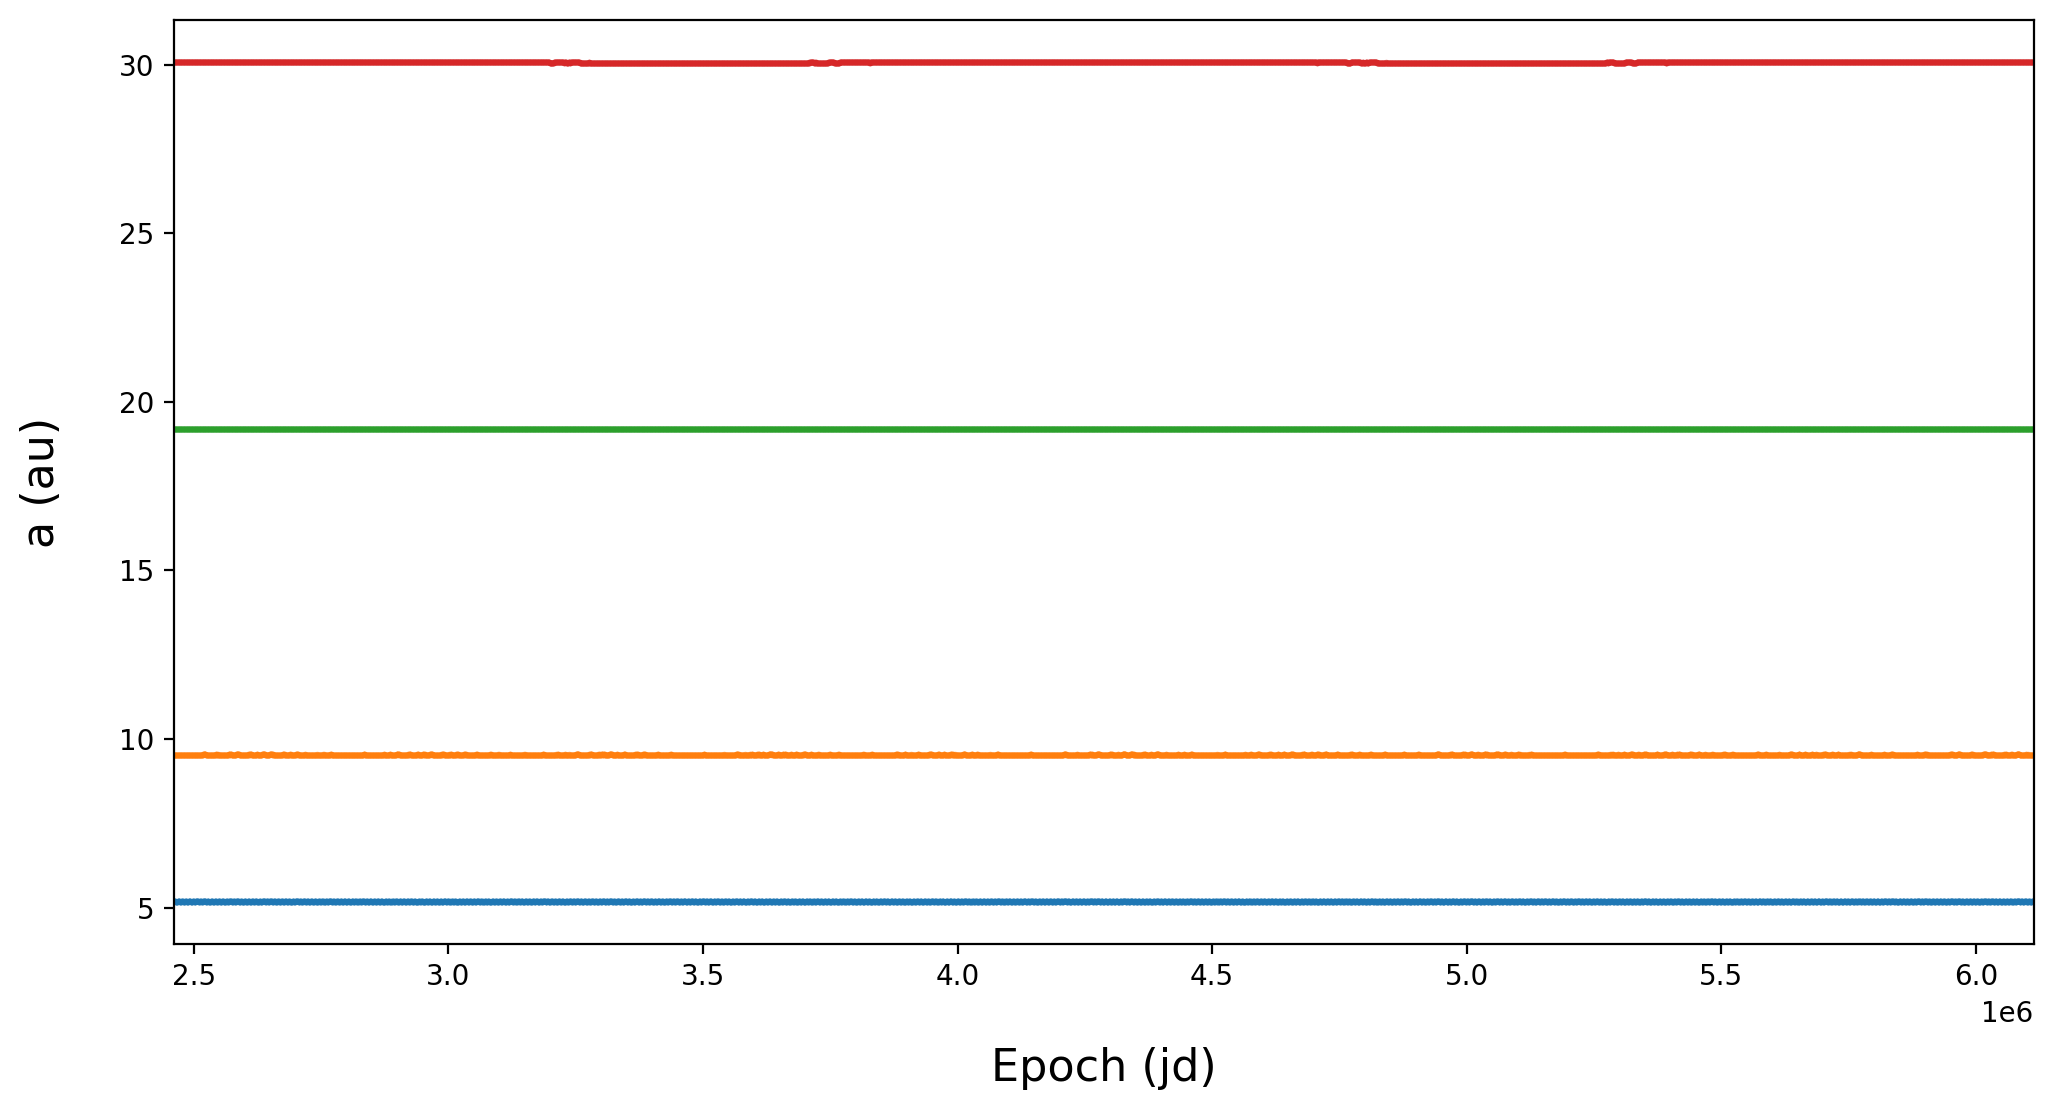

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
for idx in range(1, sim.perturbers.len()):
    semimajors = [p.a[idx] for p in perturber_snapshots]
    epochs = [p[idx].epoch.epoch for p in perturber_snapshots]
    
    ax.scatter(epochs, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('a (au)', fontsize=16, labelpad=20)
ax.set_xlim(epochs[0], epochs[-1])

In [27]:
sim.perturbers.len()

5

(0.0, 0.06598544554872549)

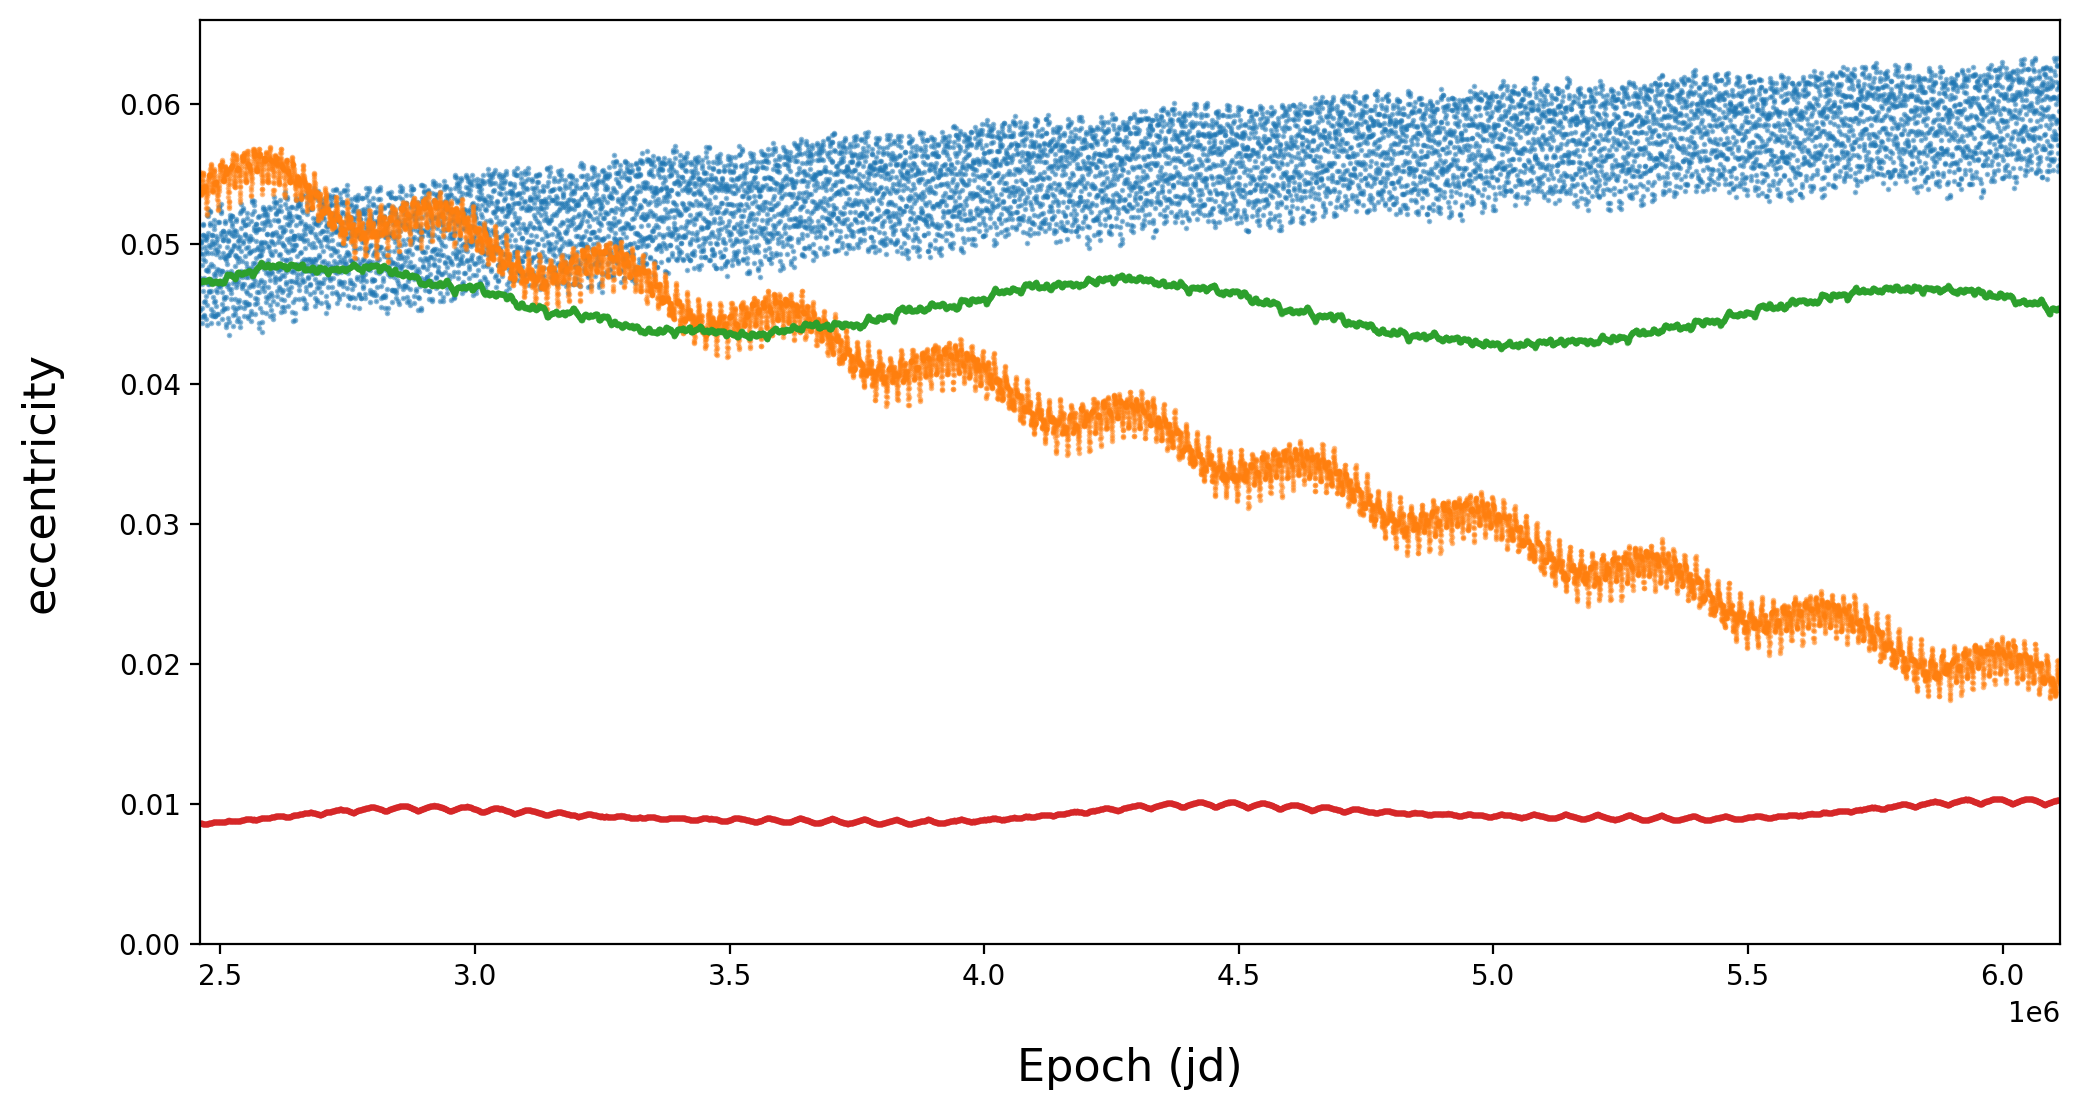

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
for idx in range(1, sim.perturbers.len()):
    semimajors = [p.e[idx] for p in perturber_snapshots]
    epochs = [p[idx].epoch.epoch for p in perturber_snapshots]
    
    ax.scatter(epochs, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('eccentricity', fontsize=16, labelpad=20)
ax.set_xlim(epochs[0], epochs[-1])
ax.set_ylim(bottom=0.0)

In [29]:
x, y, z = np.ravel([p.x for p in particle_snapshots]), np.ravel([p.y for p in particle_snapshots]), np.ravel([p.z for p in particle_snapshots])
px, py, pz = np.ravel([p.x for p in perturber_snapshots]), np.ravel([p.y for p in perturber_snapshots]), np.ravel([p.z for p in perturber_snapshots])

(-50.0, 50.0)

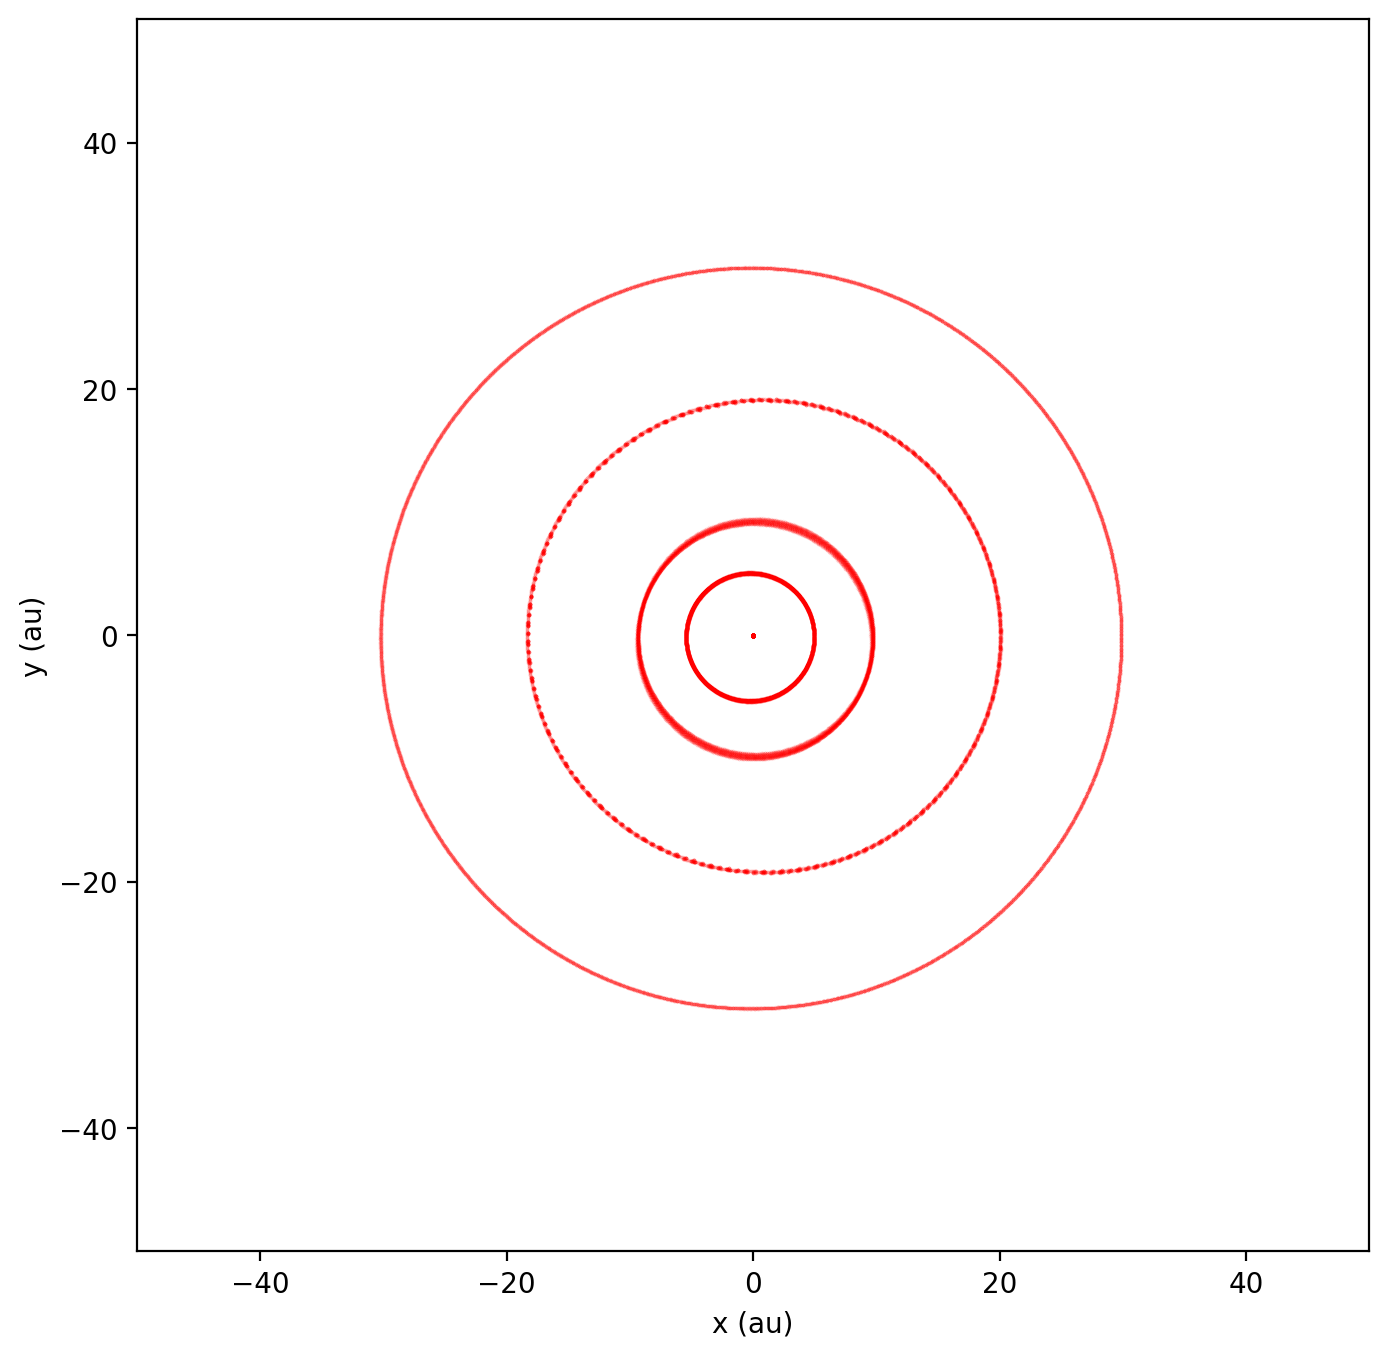

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=1, alpha=0.1, color='black')
ax.scatter(px, py, s=0.1, alpha=0.1, color='red')
ax.set_aspect('equal')
ax.set_xlabel("x (au)")
ax.set_ylabel("y (au)")
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

In [12]:
kernel.unload()

In [13]:
import rebound

In [34]:
sim = rebound.Simulation()
sim.units = ('day', 'AU', 'Msun')

for planet in planets:
    sim.add(x=planet.x, y=planet.y, z=planet.z, vx=planet.vx, vy=planet.vy, vz=planet.vz, m=planet.mass)

for rock in rocks:
    sim.add(x=rock.x, y=rock.y, z=rock.z, vx=rock.vx, vy=rock.vy, vz=rock.vz)

sim.integrator = 'ias15'
sim.dt = 50.0
#sim.t = epochs[0].epoch
sim.t = epochs[0].epoch
sim.testparticle_type = 1


sim.move_to_com()

In [35]:
%%time
sim.step()

CPU times: user 245 µs, sys: 210 µs, total: 455 µs
Wall time: 328 µs


In [26]:
sim.dt

109.67628497968484